In [8]:
# Physics informed neural networks

import numpy as np
import random
import matplotlib.pyplot as plt

# number of points
nx=256
nt=100

# equation variable
rho=1

# Sample points for our three conditions 
Nf  = 100   # pde condition
Nbc = 2     # boundary condition
N0  = 2     # initial condition 

# Reaction function
def reaction(u0, rho, dt):
    """ solution of du/dt = rho*u*(1-u) with u0 = u(x,t=0) """
    numerator = u0 * np.exp(rho * dt)
    denominator = u0 * np.exp(rho * dt) + 1 - u0
    u = numerator / denominator
    return u

def reaction_solution(rho, nx, nt):
    """ discrete solution of du/dt = rho*u*(1-u) with u0 = u(x,t=0) """
    L = 2*np.pi # Lenght 
    T = 1       # Time
    dx = L/nx
    dt = T/nt
    x = np.arange(0, 2*np.pi, dx) # (256,)
    t = np.linspace(0, T, nt).reshape(-1, 1) # (100,1)
    X, T = np.meshgrid(x, t) # X (100,256) = [[0......2pi],
                             #                [0......2pi],
                             #                    ...
                             #                [0......2pi]], 
                             #
                             # T (100,256) = [[0........0],
                             #                [0.01..0.01],
                             #                [1........1]]
    
    # initial value: u0 = u(x,t=0)
    u0 = lambda x: np.exp(-np.power((x - np.pi)/(np.pi/4), 2.)/2.) # + np.random.uniform(-0.05,0.05,256)
    u0 = u0(x) # (256,) : u(0),...,u(2pi)
    
    # function
    u = reaction(u0, rho, T) # (100,256)
    u = u.flatten() # (25600,)
    return u


# input parameters
x = np.linspace(0, 2*np.pi, nx, endpoint=False).reshape(-1, 1) # (256,1): [0,...,2pi].T
x_noboundary = x[1:]                                           # (255,1): [0.0245,...,2pi].T 
t = np.linspace(0, 1, nt).reshape(-1, 1) # (100,1): [0,...,1].T
t_noinitial = t[1:]                      # (99,1):  [0.01,...,1].T


########## X* grid with initial condition

X, T = np.meshgrid(x, t) # X (100,256) = [[0......2pi],
                         #                [0......2pi],
                         #                [   ...    ]
                         #                [0......2pi]], 
                         #
                         # T (100,256) = [[0........0],
                         #                [0.01..0.01],
                         #                [    ...   ]
                         #                [1........1]]
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None])) 
# X_star (25600,2) = [[0,     0],
#                     [0.0245,0],
#                     [...,   0],
#                     [2pi,   0],
#                       ....
#                       ....
#                     [0,     1]
#                     [0.0245,1],
#                     [...,   1],
#                     [2pi,   1]]  


########### X* grid without initial condition

X_noboundary, T_noinitial = np.meshgrid(x_noboundary, t_noinitial) # X (99,255) = [[0.0245......2pi],
                                                                   #               [0.0245......2pi],
                                                                   #               [       ...     ]
                                                                   #               [0.0245......2pi]], 
                                                                   #
                                                                   # T (99,255) = [[0.01........0.01],
                                                                   #               [0.02........0.02],
                                                                   #               [       ...      ]
                                                                   #               [1..............1]]
X_star_noinitial_noboundary = np.hstack((X_noboundary.flatten()[:, None], T_noinitial.flatten()[:, None]))
# X_star_noinitial_noboundary  (25245,2) = [[0.0245,0.01],
#                                          [...,    0.01],
#                                          [2pi,    0.01],
#                                              ....
#                                              ....
#                                          [0.0245,   1],
#                                          [...,      1],
#                                          [2pi,      1]]   


########## sample collocation points only from the interior (where the PDE is enforced)
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
        
def sample_random(X_all, N):
    """Given an array of (x,t) points, sample N_pde points from this."""
    set_seed(0)

    idx = np.random.choice(X_all.shape[0], N, replace=False)
    X_sampled = X_all[idx, :]

    return X_sampled

X_f_train = sample_random(X_star_noinitial_noboundary, Nf) # (100,2): random (x,t) pairs 


########## u(x,t) exact solution ##########
u_vals = reaction_solution(rho, nx, nt) # Exact solution (25600,)
u_star = u_vals.reshape(-1, 1)          # Exact solution reshaped into (25600, 1) 
Exact = u_star.reshape(len(t), len(x))  # Exact on the (t,x) grid, (100,256)         ##########important##########

########## Initial condition (t=0) ##########
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) 
# T[0:1,:].shape = (1,256) and T[0:1,:].T.shape = (256,1) : [0,...,0].T,
# X[0:1,:].shape = (1,256) and X[0:1,:].T.shape = (256,1) : [0,...,2pi].T, 
# xx1.shape = (256,2) : [[0,...,2pi].T,[0,...,0].T,]

uu1 = Exact[0:1,:].T # (256,1), u(x,t=0),  uu1=[u(x1,t0),u(x2,t0),.....,u(x256,t0)].T
uu2 = Exact[:,0:1]   # (100,1), u(x=0,t),  uu2=[u(x0,t0),u(x0,t1),.....,u(x0,t100)].T 

u0

########## Boundary conditions (x=0 and x=2.pi) ##########
# x=0
x_bc_lb = np.array([x[0]]*t.shape[0]).reshape(-1, 1) # (100,1) : x_bc_lb = [0,...,0].T 
bc_lb = np.hstack((x_bc_ub, t)) # shape (100,2) boundary condition at x = 0,
                                # bc_lb = [[0   0    ],
                                #          [0   0.01 ],
                                #             ...
                                #          [0   1    ]]
                
# x=2.pi
x_bc_ub = np.array([x[-1]]*t.shape[0]).reshape(-1, 1) # (100,1) : x_bc_ub = [2pi,...,2pi].T 
bc_ub = np.hstack((x_bc_ub, t)) # shape (100,2) boundary condition at x = 2pi, 
                                # bc_ub = [[2pi   0    ],
                                #          [2pi   0.01 ],
                                #             ...
                                #          [2pi   1    ]]
                

########## TRAIN values ##########                
u_train = uu1 # (256,1) : u(x,t=0)
X_u_train = xx1 # (256,2) : (x,t=0) 
print(X_u_train.shape[-1])


#For my own system
predict_x = X_star.T

train_x=  xx1.T # [[0, .... ,2pi]
                #  [0,...0,,,,,0]]   #(2,256) , m=256
    
train_y= Exact[0:1,:] # (1,256)

train_bc_L= bc_lb.T  # [[ 0,0,.......,0]
                    #  [ 0, 0.01,....1 ]]  # (2,100), m=100
    
train_bc_R= bc_ub.T # [[2pi, 2pi, ...., 2pi]
                    #  [0, 0.01, ....., 1  ]] # (2,100), m=100
    
train_x_rdn = X_f_train.T # [[.....x........]
                          #  [......t...... ]]
print(X_u_train)

[[6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25864161]
 [6.25

In [2]:
def sigmoid(Z, target):
    """
    sigmoid activation function
    
    Arguments:
    Z      -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'
    
    Returns:
    A     -- output of sigmoid(z), sigmoid'(z), or sigmoid''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    if target = 'forward':
        A = 1/(1+np.exp(-Z))
    
    elif target = 'first_derivative':
        A = (np.exp(-Z))/(1+np.exp(-Z))**2
    
    elif target = 'second_derivative':
        A = 2 * (np.exp(-2*Z))/(1+np.exp(-Z))**3 - (np.exp(-Z))/(1+np.exp(-Z))**2
        
    assert(A.shape == Z.shape)
    cache = Z
    return A, cache
    

def relu(Z, target):
    """
    RELU activation function

    Arguments:
    Z -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'

    Returns:
    A -- output of relu(z), relu'(z), or relu''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    if target = 'forward':
        A = np.maximum(0,Z)
        
    elif target = 'first_derivative':
        A[Z>0]=1
        A[Z<=0]=0
        
    elif target = 'second_derivative':
        A = Z*0
        
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def tanh(Z):
    """
    Tanh activation function

    Arguments:
    Z -- numpy array of any shape
    target -- str: 'forward', 'first_derivative' or 'second_derivative'

    Returns:
    A -- output of tanh(z), tanh'(z), or tanh''(z). Same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """

    if target = 'forward':
        A = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
        
    elif target = 'first_derivative':
        A = 4/(np.exp(Z) + np.exp(-Z))**2
        
    elif target = 'second_derivative':
        A = (8 * np.exp(-Z))/(np.exp(Z) + np.exp(-Z))**3 - (8 * np.exp(Z))/(np.exp(Z) + np.exp(-Z))**3
        
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache



def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

""" tanh """


def tanh_backward(dA, cache):
    
    Z = cache
    
    s = (np.exp(Z) - np.exp(-Z))/(np.exp(Z) + np.exp(-Z))
    dZ = dA * (1 - s**2)
    
    assert (dZ.shape == Z.shape)
    
    return dZ
 


def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)          # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1]) #*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    
    Z = W.dot(A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

def linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python dictionary containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """
    
    if activation == "sigmoid":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
    
    elif activation == "relu":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    elif activation == "tanh":
        # Inputs: "A_prev, W, b". Outputs: "A, activation_cache".
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = tanh(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

def L_model_forward(X, parameters,bulk_activation):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters['W' + str(l)], parameters['b' + str(l)], activation = bulk_activation)
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters['W' + str(L)], parameters['b' + str(L)], activation = "tanh")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # Compute loss from aL and y.
    #cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    cost = (1/m)*np.sum((AL - Y) ** 2)
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1./m * np.dot(dZ,A_prev.T)
    db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T,dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "tanh":
        dZ = tanh_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

def L_model_backward(AL, Y, caches, bulk_activation, loss):

    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    if loss == "binary":
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL)) 
    
    elif loss == "mean":
        dAL = 2 * (AL - Y)
    
    elif loss=='pde':
        dAL=1
        
    else:
        quit()
        
    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "AL, Y, caches". Outputs: "grads["dAL"], grads["dWL"], grads["dbL"]
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "tanh")
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = bulk_activation)
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p


In [82]:
### CONSTANTS ###
layers_dims = [2, 50, 50, 50, 1] #  4-layer model

# GRADED FUNCTION: L_layer_model

def L_layer_model_separate(X, Y, bcL, bcR, xrdn, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, bulk_activation='relu'):#lr was 0.009
    

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters(layers_dims)
    parametersBC = initialize_parameters(layers_dims)
    parametersPDE = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        
        AL, caches = L_model_forward(X, parameters, bulk_activation)
        ALL, cachesL = L_model_forward(bcL, parametersBC, bulk_activation)
        ALR, cachesR = L_model_forward(bcR, parametersBC, bulk_activation)
        ALPDE, cachesPDE = L_model_forward(xrdn, parametersPDE, bulk_activation)
        
        # PDE
        gradsPDE = L_model_backward(ALPDE, ALPDE, cachesPDE, bulk_activation, 'pde')
        u_t = gradsPDE["dA" + str(0)]
        f = u_t[1,:] - rho*ALPDE + rho*ALPDE**2
        m = f.shape[1]
        A0 = np.zeros(m)
        
        
        cost = compute_cost(AL, Y)
        costBC = compute_cost(ALL, ALR)
        costPDE = compute_cost(f, 0)
        
        grads = L_model_backward(AL, Y, caches, bulk_activation, 'mean')
        gradsL = L_model_backward(ALL, ALR, cachesL, bulk_activation, 'mean')
        gradsR = L_model_backward(ALR, ALL, cachesR, bulk_activation, 'mean')
        
        parameters = update_parameters(parameters, grads, learning_rate)
        parametersBC = update_parameters(parametersBC, gradsL, learning_rate)
        parametersBC = update_parameters(parametersBC, gradsR, learning_rate)
      
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("cost and costBC after iteration %i: %f %f" %(i, cost, costBC))
        if print_cost and i % 100 == 0:
            costs.append(costBC)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost2')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

cost and costBC after iteration 0: 0.143654 0.162582
cost and costBC after iteration 100: 0.128511 0.008808
cost and costBC after iteration 200: 0.124474 0.000409
cost and costBC after iteration 300: 0.123223 0.000047
cost and costBC after iteration 400: 0.122707 0.000016
cost and costBC after iteration 500: 0.122309 0.000010
cost and costBC after iteration 600: 0.121423 0.000007
cost and costBC after iteration 700: 0.118888 0.000006
cost and costBC after iteration 800: 0.116708 0.000005
cost and costBC after iteration 900: 0.110778 0.000005
cost and costBC after iteration 1000: 0.107377 0.000004
cost and costBC after iteration 1100: 0.103657 0.000004
cost and costBC after iteration 1200: 0.099525 0.000004
cost and costBC after iteration 1300: 0.094934 0.000003
cost and costBC after iteration 1400: 0.089850 0.000003
cost and costBC after iteration 1500: 0.085076 0.000003
cost and costBC after iteration 1600: 0.089540 0.000003
cost and costBC after iteration 1700: 0.085090 0.000003
cost

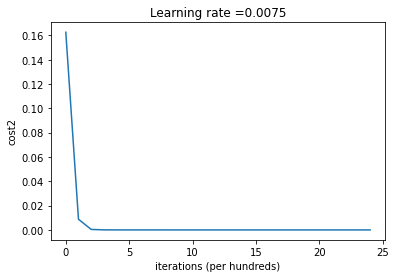

In [83]:
parameters = L_layer_model_separate(train_x, train_y, train_bc_L, train_bc_R, train_x_rdn, layers_dims, num_iterations = 2500, print_cost = True, bulk_activation='relu')

In [87]:
### CONSTANTS ###
layers_dims = [2, 50, 50, 50, 1] #  4-layer model

# GRADED FUNCTION: L_layer_model

def L_layer_model_together(X, Y, bcL, bcR, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False, bulk_activation='relu'):#lr was 0.009
    

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    
    parameters = initialize_parameters(layers_dims)
    parametersBC = initialize_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        
        AL, caches = L_model_forward(X, parameters, bulk_activation)
        ALL, cachesL = L_model_forward(bcL, parameters, bulk_activation)
        ALR, cachesR = L_model_forward(bcR, parameters, bulk_activation)
        
        
        cost = compute_cost(AL, Y)
        costBC = compute_cost(ALL, ALR)
        costT = cost + costBC
        
        grads = L_model_backward(AL, Y, caches, bulk_activation)
        gradsL = L_model_backward(ALL, ALR, cachesL, bulk_activation)
        gradsR = L_model_backward(ALR, ALL, cachesR, bulk_activation)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        parameters = update_parameters(parameters, gradsL, learning_rate)
        parameters = update_parameters(parameters, gradsR, learning_rate)
      
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("cost and costBC after iteration %i: %f" %(i, costT))
        if print_cost and i % 100 == 0:
            costs.append(costT)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost2')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

cost and costBC after iteration 0: 0.306236
cost and costBC after iteration 100: 0.147308
cost and costBC after iteration 200: 0.126273
cost and costBC after iteration 300: 0.124639
cost and costBC after iteration 400: 0.123638
cost and costBC after iteration 500: 0.123627
cost and costBC after iteration 600: 0.122887
cost and costBC after iteration 700: 0.122591
cost and costBC after iteration 800: 0.121607
cost and costBC after iteration 900: 0.120996
cost and costBC after iteration 1000: 0.120588
cost and costBC after iteration 1100: 0.119196
cost and costBC after iteration 1200: 0.117668
cost and costBC after iteration 1300: 0.115074
cost and costBC after iteration 1400: 0.112439
cost and costBC after iteration 1500: 0.110323
cost and costBC after iteration 1600: 0.107479
cost and costBC after iteration 1700: 0.105768
cost and costBC after iteration 1800: 0.103258
cost and costBC after iteration 1900: 0.100195
cost and costBC after iteration 2000: 0.095757
cost and costBC after ite

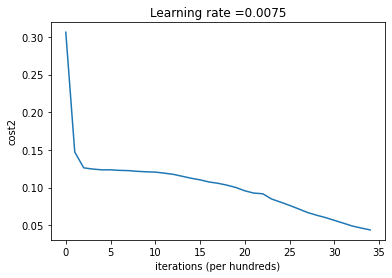

In [90]:
parameters = L_layer_model_together(train_x, train_y, train_bc_L, train_bc_R, layers_dims, num_iterations = 3500, print_cost = True, bulk_activation='relu')

In [6]:
import numpy as np
nx=256
nt=100
x = np.linspace(0, 2*np.pi, nx, endpoint=False).reshape(-1, 1) # (256,1): [0,...,2pi].T
x_noinit = x[1:]                                               # (255,1): [0.0245,...,2pi].T 
t = np.linspace(0, 1, nt).reshape(-1, 1) # (100,1): [0,...,1].T
t_noinit = t[1:]                         # (99,1):  [0.01,...,1].T


# grid parameters with initial condition
xgrid, tgrid = np.meshgrid(x, t) # xgrid (100,256) = [[0......2pi],
                                 #                    [0......2pi],
                                 #                    [   ...    ]
                                 #                    [0......2pi]], 
                                 #
                                 # tgrid (100,256) = [[0........0],
                                 #                    [0.01..0.01],
                                 #                    [    ...   ]
                                 #                    [1........1]]
X_grid_flatten = np.hstack((xgrid.flatten()[:, None], tgrid.flatten()[:, None])) 
# X_flatten (25600,2) = [[0,     0],
#                        [0.0245,0],
#                        [...,   0],
#                        [2pi,   0],
#                           ....
#                           ....
#                        [0,     1]
#                        [0.0245,1],
#                        [...,   1],
#                        [2pi,   1]]  


In [5]:
X_grid_flatten.T 

array([[0.        , 0.02454369, 0.04908739, ..., 6.20955423, 6.23409792,
        6.25864161],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [8]:
np.random.randn(2,3)*0.1

array([[ 0.08439696, -0.03464089,  0.1429124 ],
       [ 0.03159791, -0.04760369,  0.13350452]])

In [10]:
np.random.randn(2, 3) / np.sqrt(3)

array([[ 0.10500052,  0.33146537,  0.36958305],
       [ 0.84173015, -0.24411527, -0.10219934]])